In [1]:
import torch
import cv2
import numpy as np
from efficientnet_pytorch import EfficientNet
from torch.nn import functional as F
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from captum.attr import LayerGradCam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
# Cargar la red EfficientNet pre-entrenada
model = EfficientNet.from_pretrained('efficientnet-b2')

# Congelar las primeras capas
for name, param in model.named_parameters():
    if not name.startswith('_conv_head.') and not name.startswith('_fc.') and not name.startswith('_bn1.') and not name.startswith('_blocks.22') and not name.startswith('_blocks.21') and not name.startswith('_blocks.20') and not name.startswith('_blocks.19') and not name.startswith('_blocks.18') and not name.startswith('_blocks.17') and not name.startswith('_blocks.16') and not name.startswith('_blocks.15'): 
        param.requires_grad = False

# Reemplazar el clasificador lineal con uno personalizado
num_ftrs = model._fc.in_features
model._fc = torch.nn.Linear(num_ftrs, 1)

# Cargar los pesos y los bias de la red guardada
checkpoint = torch.load("best_model_EfficientNetB2_FrozenLast8.pth")
model.load_state_dict(checkpoint)



Loaded pretrained weights for efficientnet-b2


<All keys matched successfully>

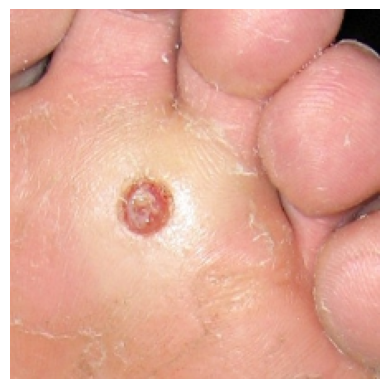

In [13]:
import pickle  
from PIL import Image
import torchvision.transforms as transforms
import torch

# Cargar la imagen
img = Image.open("/Users/guill/Escritorio/TesisLisboa/archive/DFU/TestSet/test/Abnormal (9).jpg")


img = np.array(img) 
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

plt.imshow(img)
plt.axis('off')
plt.savefig("Abnormal_9.png", dpi=500, bbox_inches='tight', pad_inches=0.0)
plt.show()


# Transformaciones
transform = transforms.Compose([
        #transforms.Resize((160, 160)),
        #transforms.Resize((224, 224)),
        #transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])



# Aplicar las transformaciones
img_tensor1 = transform(img).unsqueeze(0)



# Normalize the image to be in the range of [0, 1]
img_tensor = img_tensor1.clone().detach().float() / 255.0





#img_tensor.requires_grad = True
#output = model(img_tensor)

Prediction: Abnormal (1.00)


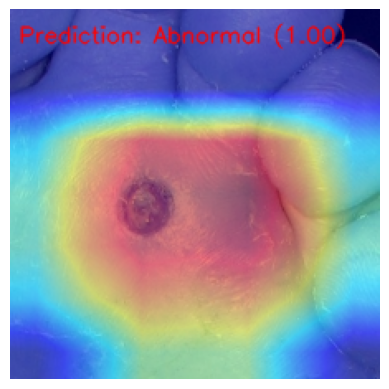

In [11]:


#target_layer = [model._blocks[22]._project_conv]
target_layer = [model._blocks[21]._project_conv]
#target_layer = [model._blocks[20]._project_conv]
#target_layer = [model._blocks[19]._project_conv]
#target_layer = [model._blocks[18]._project_conv]
#target_layer = [model._blocks[17]._project_conv]
#target_layer = [model._blocks[16]._project_conv]
#target_layer = [model._blocks[15]._project_conv]



with torch.no_grad():
    output = model(img_tensor1)
    probabilities = torch.sigmoid(output).cpu().numpy()
    prediction = (torch.sigmoid(output) >= 0.5)[:, 0].item()
    
    if prediction == 1:
        text = f"Prediction: Normal ({probabilities.item():.2f})"
    else:
        text = f"Prediction: Abnormal ({( 1- probabilities.item()):.2f})"
        
print(text)


cam = GradCAM(model=model, target_layers=target_layer)

targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=img_tensor, targets=targets,eigen_smooth=True,aug_smooth=True)


# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img / 255.0 , grayscale_cam, use_rgb=True)






# Agrega texto en la imagen
font = cv2.FONT_HERSHEY_SIMPLEX
#text = f"Prediction: {'Normal' if predictions.item()==0 else 'Abnormal'} ({probabilities.item()*100:.2f}%)"

#text = f"Prediction: {predicted_labels[-1]} ({predicted_probs[-1][0]*100:.2f}%)"
cv2.putText(visualization, text, (5, 20), font, 0.45, (255, 0, 0), 1, cv2.LINE_AA)


plt.imshow(visualization)
plt.axis('off')
plt.savefig("Abnormal_9_L21.png", dpi=500, bbox_inches='tight', pad_inches=0.0)
plt.show()



In [4]:
'''
import pickle  
from PIL import Image
import torchvision.transforms as transforms
import torch

# Cargar la imagen
img = Image.open("/Users/guill/Escritorio/TesisLisboa/archive/DFU/TestSet/test/Abnormal (147).jpg")


img = np.array(img) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (224, 224))



# Transformaciones
transform = transforms.Compose([
        #transforms.Resize((160, 160)),
        #transforms.Resize((224, 224)),
        #transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])



# Aplicar las transformaciones
img_tensor = transform(img).unsqueeze(0)



#img_tensor.requires_grad = True

target_layer = model._blocks[22]._project_conv
gradcam_layer = LayerGradCam(model, target_layer)
attributions = gradcam_layer.attribute(img_tensor)
#print(attributions.shape)


import matplotlib.pyplot as plt
import numpy as np

heatmap = np.transpose(attributions.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
# Ajustar el rango de valores de atribución utilizando la normalización z-score
heatmap_mean = np.mean(heatmap)
heatmap_std = np.std(heatmap)
heatmap_norm = (heatmap - heatmap_mean) / heatmap_std

heatmap_norm = np.maximum(heatmap_norm, 0)
heatmap_norm /= np.max(heatmap_norm)

# Mostrar la imagen con el heatmap superpuesto
plt.imshow(heatmap_norm)
plt.show()
big_heatmap = cv2.resize(heatmap_norm, dsize=(541, 545), 
                         interpolation=cv2.INTER_CUBIC)

plt.imshow(big_heatmap, cmap='rainbow')

'''



'\nimport pickle  \nfrom PIL import Image\nimport torchvision.transforms as transforms\nimport torch\n\n# Cargar la imagen\nimg = Image.open("/Users/guill/Escritorio/TesisLisboa/archive/DFU/TestSet/test/Abnormal (147).jpg")\n\n\nimg = np.array(img) \nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n#img = cv2.resize(img, (224, 224))\n\n\n\n# Transformaciones\ntransform = transforms.Compose([\n        #transforms.Resize((160, 160)),\n        #transforms.Resize((224, 224)),\n        #transforms.CenterCrop((128, 128)),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),\n])\n\n\n\n# Aplicar las transformaciones\nimg_tensor = transform(img).unsqueeze(0)\n\n\n\n#img_tensor.requires_grad = True\n\ntarget_layer = model._blocks[22]._project_conv\ngradcam_layer = LayerGradCam(model, target_layer)\nattributions = gradcam_layer.attribute(img_tensor)\n#print(attributions.shape)\n\n\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n

In [5]:
'''
import matplotlib.pyplot as plt

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Mostrar imagen original en el primer subplot
ax1.imshow(img)
ax1.set_title('Imagen original')

# Mostrar atribuciones resaltadas en el segundo subplot
ax2.imshow(heatmap, cmap='magma')
ax2.set_title('Grad-CAM')

# Ajustar el espaciado entre subplots para que no se superpongan
fig.tight_layout()

# Mostrar la figura
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Crear figura con dos subplots\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))\n\n# Mostrar imagen original en el primer subplot\nax1.imshow(img)\nax1.set_title('Imagen original')\n\n# Mostrar atribuciones resaltadas en el segundo subplot\nax2.imshow(heatmap, cmap='magma')\nax2.set_title('Grad-CAM')\n\n# Ajustar el espaciado entre subplots para que no se superpongan\nfig.tight_layout()\n\n# Mostrar la figura\nplt.show()\n"

In [6]:
'''


# Calcular Grad-CAM attribution
 #model._blocks[22]._bn2
gradcam_layer = LayerGradCam(model, model._conv_head)
attr = gradcam_layer.attribute(img_tensor, target=0)

# Visualizar la imagen con Grad-CAM
original_image_np = img_tensor.squeeze().detach().cpu().numpy().transpose((1,2,0))
#attr_np = attr.squeeze(0).detach().cpu().numpy()
attr_np = attr.squeeze(0).detach().cpu().numpy().transpose((1,2,0))
attr_np = np.maximum(attr_np, 0) # ReLU to keep only positive attributions


# Redimensionar las atribuciones para que coincidan con el tamaño de la imagen original
#attr_np = cv2.resize(attr_np, (original_image_np.shape[1], original_image_np.shape[0]))


attr_np = (attr_np - np.min(attr_np)) / (np.max(attr_np) - np.min(attr_np)) # normalize to [0,1]

#attr_np = (attr_np * 255 / np.max(attr_np)).astype('uint8') # convert to uint8 and scale to [0,255]
#attr_np = np.squeeze(attr_np[:,:,0]) # reshape to 2D array


# Mezclar las atribuciones con la imagen original
#attr_np = cv2.applyColorMap(np.uint8(255*attr_np), cv2.COLORMAP_JET)
#attr_np = cv2.cvtColor(attr_np, cv2.COLOR_BGR2RGB)

#vis_img = cv2.addWeighted(original_image_np, 0.5, attr_np, 0.5, 0.0)
#plt.imshow(vis_img)

plt.imshow(attr_np, cmap='magma')

# Obtener la imagen con las atribuciones resaltadas
masked_image = viz.visualize_image_attr(attr_np, img_tensor.squeeze().detach().cpu().numpy().transpose((1,2,0)), method="blended_heat_map", sign="all")
print(type(masked_image))

# Convertir la imagen a formato BGR para usar con OpenCV
masked_image_bgr = cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR)

# Mezclar la máscara con la imagen real usando addWeighted()
alpha = 0.5 # factor de mezcla
mixed_image = cv2.addWeighted(masked_image_bgr, alpha, original_image_np, 1-alpha, 0)

# Mostrar la imagen resultante
plt.imshow(mixed_image)
plt.axis('off')
plt.show()

'''

'\n\n\n# Calcular Grad-CAM attribution\n #model._blocks[22]._bn2\ngradcam_layer = LayerGradCam(model, model._conv_head)\nattr = gradcam_layer.attribute(img_tensor, target=0)\n\n# Visualizar la imagen con Grad-CAM\noriginal_image_np = img_tensor.squeeze().detach().cpu().numpy().transpose((1,2,0))\n#attr_np = attr.squeeze(0).detach().cpu().numpy()\nattr_np = attr.squeeze(0).detach().cpu().numpy().transpose((1,2,0))\nattr_np = np.maximum(attr_np, 0) # ReLU to keep only positive attributions\n\n\n# Redimensionar las atribuciones para que coincidan con el tamaño de la imagen original\n#attr_np = cv2.resize(attr_np, (original_image_np.shape[1], original_image_np.shape[0]))\n\n\nattr_np = (attr_np - np.min(attr_np)) / (np.max(attr_np) - np.min(attr_np)) # normalize to [0,1]\n\n#attr_np = (attr_np * 255 / np.max(attr_np)).astype(\'uint8\') # convert to uint8 and scale to [0,255]\n#attr_np = np.squeeze(attr_np[:,:,0]) # reshape to 2D array\n\n\n# Mezclar las atribuciones con la imagen original\

In [7]:


'''
# Obtener la capa de características de interés
#target_layer = model._blocks[22]._bn2
#target_layer =model._fc.bias

# Activar el modo de evaluación y gradiente
model.eval()
model.requires_grad_()

# Calcular los mapas de activación

activations = model(img_tensor)
activations.backward(gradient=torch.ones_like(activations)* 0.1)

# Calcular las activaciones nuevamente después de la retropropagación
activations = model(img_tensor)



# Calcular los gradientes de las activaciones con respecto a la imagen
grads = torch.autograd.grad(activations, img_tensor, 
                            grad_outputs=torch.ones_like(activations),
                            retain_graph=True, create_graph=True)[0]


# Calcular los pesos de importancia de las características
weights = torch.mean(grads, axis=(2, 3), keepdim=True)
cam = torch.sum(weights * activations, axis=1, keepdim=True)
cam = F.relu(cam)
cam = F.interpolate(cam, size=img_tensor.shape[2:], mode='bilinear', align_corners=False)

cam -= torch.min(cam)
cam /= torch.max(cam) + 1e-5

print("Mínimo:", torch.min(cam).detach().numpy())
print("Máximo:", torch.max(cam).detach().numpy())


# Calcular los mapas de activación ponderados por los pesos
#map_activations = torch.sum(weights * activations, axis=1, keepdim=True)
#map_activations = F.relu(map_activations)


# Visualizar la imagen y el mapa de activación
img_array = np.array(img)

show_cam_on_image(img_array, cam.squeeze().detach().numpy())
'''

'\n# Obtener la capa de características de interés\n#target_layer = model._blocks[22]._bn2\n#target_layer =model._fc.bias\n\n# Activar el modo de evaluación y gradiente\nmodel.eval()\nmodel.requires_grad_()\n\n# Calcular los mapas de activación\n\nactivations = model(img_tensor)\nactivations.backward(gradient=torch.ones_like(activations)* 0.1)\n\n# Calcular las activaciones nuevamente después de la retropropagación\nactivations = model(img_tensor)\n\n\n\n# Calcular los gradientes de las activaciones con respecto a la imagen\ngrads = torch.autograd.grad(activations, img_tensor, \n                            grad_outputs=torch.ones_like(activations),\n                            retain_graph=True, create_graph=True)[0]\n\n\n# Calcular los pesos de importancia de las características\nweights = torch.mean(grads, axis=(2, 3), keepdim=True)\ncam = torch.sum(weights * activations, axis=1, keepdim=True)\ncam = F.relu(cam)\ncam = F.interpolate(cam, size=img_tensor.shape[2:], mode=\'bilinear\', 